<a href="https://colab.research.google.com/github/agsilver108/mimic-code/blob/main/Amit_Gujrathi_(asg4338)_Mimic3_NLPv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

!gcloud projects list

from google.cloud import bigquery
import os

from google.colab import drive
drive.mount('/content/drive')

mimic_filespath = "/content/drive/MyDrive/mimic3_data"
os.chdir(mimic_filespath)


Authenticated
PROJECT_ID                  NAME                        PROJECT_NUMBER
asg4338-mimic3-v1           ASG4338 MIMIC3 v1           176181609696
clinical-entity-extraction  clinical-entity-extraction  321960627270
elaborate-art-449407-m0     ASG4338 MIMIC3 v1           340556621126
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

# Load patients data
patients_df = pd.read_csv('PATIENTS.csv.gz')
patients_df.head()

# Load admissions data
admissions_df = pd.read_csv('ADMISSIONS.csv.gz')
admissions_df.head()

# Load noteevents data
noteevents_df = pd.read_csv('NOTEEVENTS.csv', low_memory=False).set_index('ROW_ID')
noteevents_df.head()

#Load diagnoses_icd data
diagnoses_icd_df = pd.read_csv('DIAGNOSES_ICD.csv.gz').set_index('ROW_ID')
diagnoses_icd_df.head()


,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
ROW_ID,,,,
1297,109,172335,1.0,40301
1298,109,172335,2.0,486
1299,109,172335,3.0,58281
1300,109,172335,4.0,5855
1301,109,172335,5.0,4254


In [4]:
# Filter NoteEvents by Discharge Summary and Extract Text

# Filter NoteEvents by Discharge Summary
discharge_summaries_flt_df = noteevents_df.loc[noteevents_df['CATEGORY'] == 'Discharge summary',
                                               ['SUBJECT_ID', 'HADM_ID', 'TEXT']]

# Print discharge_summaries_flt_df top 10
#print(discharge_summaries_flt_df.head(10))

# Extract Text
discharge_summaries_text = discharge_summaries_flt_df['TEXT']
#print(discharge_summaries_text.head(10))


In [5]:
# Load d_icd_diagnoses data
icd_diagnoses_df = pd.read_csv('D_ICD_DIAGNOSES.csv.gz')
icd_diagnoses_df.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [6]:
# Join icd_diagnoses_df with diagnoses_icd_df and filter the icd9 code on short_title
# for "Lymphoma"

import pandas as pd
# Merge the two dataframes
merged_df = pd.merge(icd_diagnoses_df, diagnoses_icd_df, how='inner')
#print(merged_df.head(10))

# Filter the merged dataframe
lymphoma_df = merged_df[merged_df['SHORT_TITLE'].str.contains("lymphoma", na=False)]
#print(lymphoma_df.head(100))

# Print the filtered dataframe (optional)
print(lymphoma_df.head(20))


       ROW_ID ICD9_CODE               SHORT_TITLE  \
36699    1699     20201     Nodular lymphoma head   
36700    1699     20201     Nodular lymphoma head   
36701    1701     20203    Nodular lymphoma abdom   
36702    1701     20203    Nodular lymphoma abdom   
36703    1703     20205   Nodular lymphoma inguin   
36704    1704     20206   Nodular lymphoma pelvic   
36705    1706     20208     Nodular lymphoma mult   
36706    1706     20208     Nodular lymphoma mult   
36707    1706     20208     Nodular lymphoma mult   
36708    1706     20208     Nodular lymphoma mult   
45486    2148     20071  Large cell lymphoma head   

                                              LONG_TITLE  SUBJECT_ID  HADM_ID  \
36699  Nodular lymphoma, lymph nodes of head, face, a...       24483   126391   
36700  Nodular lymphoma, lymph nodes of head, face, a...       56552   196064   
36701      Nodular lymphoma, intra-abdominal lymph nodes       70754   116929   
36702      Nodular lymphoma, intra-abdo

In [7]:
# merge lymphoma_df and discharge_summaries_flt_df on subject_id and hadm_id

import pandas as pd
lymphoma_patients_disch_summaries_df = pd.merge(lymphoma_df,
                                                discharge_summaries_flt_df,
                                                on=['SUBJECT_ID', 'HADM_ID'], how='inner')
print(lymphoma_patients_disch_summaries_df.head(20))


    ROW_ID ICD9_CODE               SHORT_TITLE  \
0     1699     20201     Nodular lymphoma head   
1     1699     20201     Nodular lymphoma head   
2     1699     20201     Nodular lymphoma head   
3     1701     20203    Nodular lymphoma abdom   
4     1701     20203    Nodular lymphoma abdom   
5     1703     20205   Nodular lymphoma inguin   
6     1704     20206   Nodular lymphoma pelvic   
7     1706     20208     Nodular lymphoma mult   
8     1706     20208     Nodular lymphoma mult   
9     1706     20208     Nodular lymphoma mult   
10    2148     20071  Large cell lymphoma head   

                                           LONG_TITLE  SUBJECT_ID  HADM_ID  \
0   Nodular lymphoma, lymph nodes of head, face, a...       24483   126391   
1   Nodular lymphoma, lymph nodes of head, face, a...       56552   196064   
2   Nodular lymphoma, lymph nodes of head, face, a...       56552   196064   
3       Nodular lymphoma, intra-abdominal lymph nodes       70754   116929   
4       N

In [8]:
#Limit the result set to ICD9_CODE, SHORT_TITLE, SUBJECT_ID, HADM_ID, and TEXT

lymphoma_patients_disch_summaries_df = lymphoma_patients_disch_summaries_df[
    ['ICD9_CODE', 'SHORT_TITLE', 'SUBJECT_ID', 'HADM_ID', 'TEXT']]
#print(lymphoma_patients_disch_summaries_df.head(20))

lymphoma_patients_disch_summaries_df.to_csv('lymphoma_patients_disch_summaries.csv',
                                            index=False)

<ipython-input-9-bb532a70bf3f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='SHORT_TITLE', data=lymphoma_patients_disch_summaries_df, palette='viridis', order=title_counts.index) # Use a colorful palette


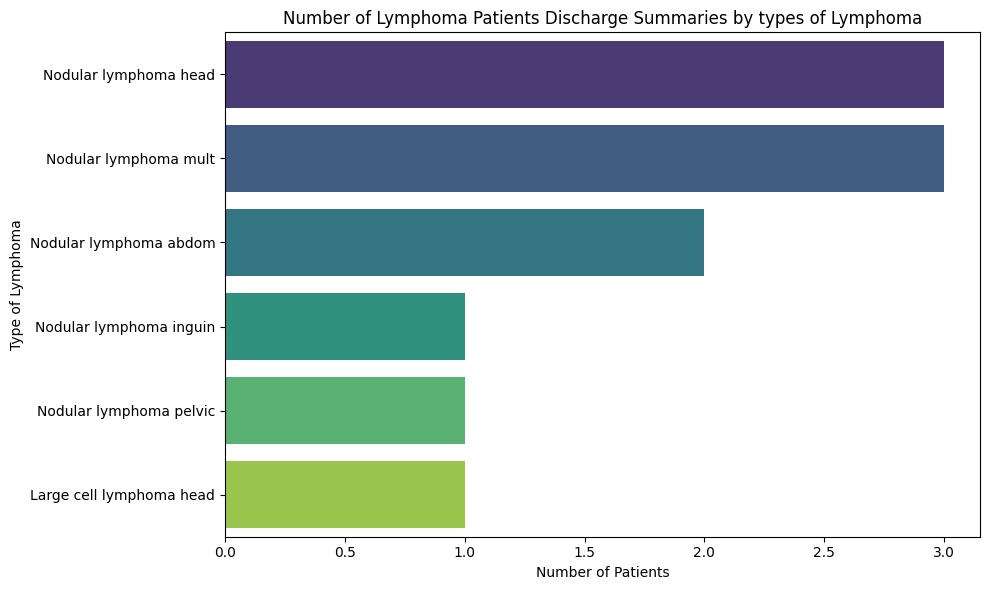

In [9]:
# prompt: visualize the number of lymphoma_patients_disch_summaries_df by SHORT_TITLE using horizontal bar chart with colorful bars

import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each SHORT_TITLE
title_counts = lymphoma_patients_disch_summaries_df['SHORT_TITLE'].value_counts()

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.countplot(y='SHORT_TITLE', data=lymphoma_patients_disch_summaries_df, palette='viridis', order=title_counts.index) # Use a colorful palette
plt.xlabel('Number of Patients')
plt.ylabel('Type of Lymphoma')
plt.title('Number of Lymphoma Patients Discharge Summaries by types of Lymphoma')
plt.tight_layout()
plt.show()


In [10]:
# load the spaCy model for Clinical notes

!pip install spacy
!python -m spacy download en_core_web_sm # or a larger model if needed, e.g., en_core_web_lg

import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")


2025-02-15 08:39:22.838019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739608763.116479   28479 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739608763.189826   28479 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-15 08:39:23.778695: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-15 08:39:31.979526: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

In [11]:
lymphoma_summary_df = pd.read_csv('lymphoma_patients_disch_summaries.csv')
lymphoma_summary_df.head()

,ICD9_CODE,SHORT_TITLE,SUBJECT_ID,HADM_ID,TEXT
0,20201,Nodular lymphoma head,24483,126391,Admission Date: [**2177-9-27**] ...
1,20201,Nodular lymphoma head,56552,196064,Admission Date: [**2150-11-25**] ...
2,20201,Nodular lymphoma head,56552,196064,Admission Date: [**2150-11-27**] ...
3,20203,Nodular lymphoma abdom,70754,116929,Admission Date: [**2147-7-4**] D...
4,20203,Nodular lymphoma abdom,96779,132235,Admission Date: [**2163-6-1**] D...


In [12]:
# filter lymphoma_summary_df for ICD9_CODE 20203

# Filter for ICD9_CODE 20203 - Nodular Lymphoma for abdomen
nod_lymph_abd_filtered_df = lymphoma_summary_df[lymphoma_summary_df['ICD9_CODE'] == 20203]
print(nod_lymph_abd_filtered_df.head())


   ICD9_CODE             SHORT_TITLE  SUBJECT_ID  HADM_ID  \
3      20203  Nodular lymphoma abdom       70754   116929   
4      20203  Nodular lymphoma abdom       96779   132235   

                                                TEXT  
3  Admission Date:  [**2147-7-4**]              D...  
4  Admission Date:  [**2163-6-1**]              D...  


In [13]:
# write a function to tokenize and clean the TEXT using SpaCy

import re

def tokenize_and_clean(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        # Remove punctuation and special characters
        token_text = re.sub(r'[^\w\s]', '', token.text)
        # Convert to lowercase
        token_text = token_text.lower()
        # Remove stop words and numbers
        if token_text and not token.is_stop and not token.is_punct and not token.like_num:
            tokens.append(token_text)
    return tokens


In [14]:
# write a function to extract entities from text using SpaCy

def extract_entities(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    print("*********************************************************")
    return doc



In [15]:
#apply tokenization to nod_lymph_abd_filtered_df column

nod_lymph_abd_filtered_df['tokens'] = nod_lymph_abd_filtered_df['TEXT'].apply(tokenize_and_clean)
nod_lymph_abd_filtered_df

<ipython-input-15-65c774e674fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nod_lymph_abd_filtered_df['tokens'] = nod_lymph_abd_filtered_df['TEXT'].apply(tokenize_and_clean)


,ICD9_CODE,SHORT_TITLE,SUBJECT_ID,HADM_ID,TEXT,tokens
3,20203,Nodular lymphoma abdom,70754,116929,Admission Date: [**2147-7-4**] D...,"[admission, date, , , discharge,..."
4,20203,Nodular lymphoma abdom,96779,132235,Admission Date: [**2163-6-1**] D...,"[admission, date, , , discharge,..."


In [16]:
#Extract entities from TEXT column

extract_entities(nod_lymph_abd_filtered_df.iloc[0]['TEXT'])


2147-7-4 20 28 DATE
2147-8-23 66 75 DATE
2103-7-19 99 108 DATE
4377 247 251 DATE
Surgical or Invasive Procedure 303 333 ORG
1st 465 468 CARDINAL
50% 488 491 PERCENT
2nd 521 524 ORDINAL
L 555 556 ORG
43 643 645 CARDINAL
2147-6-9 718 726 DATE
today 772 777 DATE
417 945 948 CARDINAL
2147-6-9 969 977 DATE
2147-6-13 987 996 DATE
0.9 1141 1144 CARDINAL
1501 1219 1223 DATE
Today 1297 1302 DATE
1501 1324 1328 DATE
7.8 1387 1390 CARDINAL
9.9 1411 1414 CARDINAL
ED 1562 1564 ORG
VS 1574 1576 PRODUCT
98.9 1584 1588 CARDINAL
18 95% 1599 1605 PERCENT
RA 1606 1608 ORG
8.6 1630 1633 CARDINAL
10.6 1657 1661 CARDINAL
10U 1677 1680 CARDINAL
1 1704 1705 CARDINAL
10.1 1915 1919 CARDINAL
6.7 1939 1942 CARDINAL
Nephrology 1945 1955 ORG
6.3 2111 2114 CARDINAL
MICU 2228 2232 ORG
VS 2244 2246 PRODUCT
97.4 79 2252 2259 CARDINAL
118/82 2260 2266 DATE
15 98% 2267 2273 PERCENT
RA


Past Medical History 2277 2302 ORG
Anxiety
Depression 2329 2347 ORG
Irritable 2402 2411 ORG
Hemorrhoids
Heroin 2427 2445 ORG
IVDA 2501 

Admission Date:  [**2147-7-4**]              Discharge Date:   [**2147-8-23**]

Date of Birth:  [**2103-7-19**]             Sex:   F

Service: MEDICINE

Allergies:
No Known Allergies / Adverse Drug Reactions

Attending:[**Last Name (NamePattern1) 4377**]
Chief Complaint:
Left lower leg swelling

Major Surgical or Invasive Procedure:
hemodialysis
left internal jugular hemodialysis catheter placement and
removal
right upper extremity PICC placement
chemotherapy: 1st cycle fludarabine (50% dose due to renal
function), 2nd cycle CHOP
R Nephrosotomy and L renal stent placement
R Nephrostomy and  L stent removal

History of Present Illness:
43 y.o women with a history of hepatitis C, recent lymph node
biopsy on [**2147-6-9**] at [**Hospital3 **] hospital who presents today
with left lower extremity redness and pain, who was then found
to have severe hyperkalemia and acute renal failure.

The patient recently was admitted to [**Hospital3 417**] hospital
from [**2147-6-9**] to [**2147-6-13**] 

In [17]:
# use displacy to visualize entities from TEXT

from spacy import displacy

displacy.render(nlp(nod_lymph_abd_filtered_df.iloc[0]['TEXT']), style="ent", jupyter='True')

In [26]:
# Load SciSpacy NLP with en_core_sci_md

#!pip install scispacy
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz

import scispacy
import spacy

nlp = spacy.load("en_core_sci_md")


In [29]:
# Filter lymphoma_summary_df by ICD9_code = 20206

# Filter for ICD9_CODE 20206
nod_lymph_pelvic_filtered_df = lymphoma_summary_df[lymphoma_summary_df['ICD9_CODE'] == 20206]
print(nod_lymph_pelvic_filtered_df.head())


   ICD9_CODE              SHORT_TITLE  SUBJECT_ID  HADM_ID  \
6      20206  Nodular lymphoma pelvic       73693   177173   

                                                TEXT  
6  Admission Date:  [**2195-10-14**]             ...  


In [30]:
# create functions to extract tokens and entities using SciSpacy library

def extract_entities_scispacy(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    print("*********************************************************")
    return doc

def extract_tokens_scispacy(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        # Remove punctuation and special characters
        token_text = re.sub(r'[^\w\s]', '', token.text)
        # Convert to lowercase
        token_text = token_text.lower()
        # Remove stop words and numbers
        if token_text and not token.is_stop and not token.is_punct and not token.like_num:
            tokens.append(token_text)
    return tokens


In [35]:
#apply tokenization to nod_lymph_pelvic_filtered_df column

nod_lymph_pelvic_filtered_df['tokens'] = nod_lymph_pelvic_filtered_df['TEXT'].apply(extract_tokens_scispacy)
print(nod_lymph_pelvic_filtered_df.head())

   ICD9_CODE              SHORT_TITLE  SUBJECT_ID  HADM_ID  \
6      20206  Nodular lymphoma pelvic       73693   177173   

                                                TEXT  \
6  Admission Date:  [**2195-10-14**]             ...   

                                              tokens  
6  [admission, date,  ,              , discharge,...  


<ipython-input-35-1f308a7510f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nod_lymph_pelvic_filtered_df['tokens'] = nod_lymph_pelvic_filtered_df['TEXT'].apply(extract_tokens_scispacy)


In [37]:
extract_entities_scispacy(nod_lymph_pelvic_filtered_df.iloc[0]['TEXT'])

Admission 0 9 ENTITY
Sex 127 130 ENTITY
Allergies 176 185 ENTITY
Adverse 188 195 ENTITY
Drug Reactions 196 210 ENTITY
Name3 231 236 ENTITY
LF 238 240 ENTITY
Surgical 282 290 ENTITY
Invasive Procedure:
Left parietal mass 294 332 ENTITY
History 342 349 ENTITY
Patient 370 377 ENTITY
year 386 390 ENTITY
woman 395 400 ENTITY
**Hospital1 18**] 418 435 ENTITY
evaluation 440 450 ENTITY
minute 468 474 ENTITY
post-ictal 529 539 ENTITY
EMS 545 548 ENTITY
arrival 549 556 ENTITY
reponding 569 578 ENTITY
commands 586 594 ENTITY
airway 618 624 ENTITY
**Hospital1 18**] 650 667 ENTITY
ER 696 698 ENTITY
evaluated 711 720 ENTITY
seizure 737 744 ENTITY
CT 756 758 ENTITY
head 766 770 ENTITY
left parietal brain lesion 785 811 ENTITY
neurosurgery 816 828 ENTITY
consulted 833 842 ENTITY
consult 865 872 ENTITY
patient 880 887 ENTITY
intubated 896 905 ENTITY
sedated 910 917 ENTITY
airway 922 928 ENTITY
protection 929 939 ENTITY
patients 982 990 ENTITY
intubation 998 1008 ENTITY
Nodular Lymphoma 1089 1105 ENTITY

Admission Date:  [**2195-10-14**]              Discharge Date:   [**2195-10-23**]

Date of Birth:  [**2133-8-29**]             Sex:   F

Service: MEDICINE

Allergies:
No Known Allergies / Adverse Drug Reactions

Attending:[**First Name3 (LF) 2195**]
Chief Complaint:
Seizure

Major Surgical or Invasive Procedure:
Left parietal mass removal

History of Present Illness:
Patient is a 62 year old woman who presents to [**Hospital1 18**] for
evaluation after having a 2 minute witnessed tonic clonic
seizure
while at work. She was post-ictal upon EMS arrival and was not
reponding to any commands but was protecting her airway. She was
trasnferred to [**Hospital1 18**] for further care and in the ER while being
evaluated she had another seizure. She had a CT of the head that
showed a left parietal brain lesion and neurosurgery was
consulted. Prior to arriving to consult on the patient she was
intubated and sedated for airway protection. Unable to obtain
review of systems given patients recent in

In [38]:
displacy.render(nlp(nod_lymph_pelvic_filtered_df.iloc[0]['TEXT']), style="ent", jupyter='True')

In [48]:
# Use medically trained NLP to extract specific entities
#!pip install en_ner_bc5cdr_sm
import spacy
import en_ner_bc5cdr_sm

nlp = spacy.load("en_ner_bc5cdr_sm")
doc = nlp(nod_lymph_pelvic_filtered_df.iloc[0]['TEXT'])
print([(X.text, X.label_) for X in doc.ents])
displacy.render(nlp(nod_lymph_pelvic_filtered_df.iloc[0]['TEXT']), style="ent", jupyter='True')


ModuleNotFoundError: No module named 'en_ner_bc5cdr_sm'

In [54]:
# First create corpus of entities for Word2Vec to use as input

import pandas as pd

# Assuming 'nod_lymph_pelvic_filtered_df' is already defined as in our previous code

def create_corpus(df):
    corpus = []
    for index, row in df.iterrows():
        tokens = row['tokens']
        corpus.append(tokens)
    return corpus

# Create the corpus
nod_lymph_pelvic_corpus = create_corpus(nod_lymph_pelvic_filtered_df)

# Example of accessing the corpus (first document's tokens)
print(len(nod_lymph_pelvic_corpus))
print(nod_lymph_pelvic_corpus[:10])

1111

[['admission', 'date', ' ', '             ', 'discharge', 'date', '  ', '\n\n', 'date', 'birth', ' ', '            ', 'sex', '  ', 'f', '\n\n', 'service', 'medicine', '\n\n', 'allergies', '\n', 'known', 'allergies', 'adverse', 'drug', 'reactions', '\n\n', 'attendingfirst', 'name3', 'lf', '\n', 'chief', 'complaint', '\n', 'seizure', '\n\n', 'major', 'surgical', 'invasive', 'procedure', '\n', 'left', 'parietal', 'mass', 'removal', '\n\n', 'history', 'present', 'illness', '\n', 'patient', 'year', 'old', 'woman', 'presents', 'hospital1', '\n', 'evaluation', 'having', 'minute', 'witnessed', 'tonic', 'clonic', '\n', 'seizure', '\n', 'work', 'postictal', 'ems', 'arrival', '\n', 'reponding', 'commands', 'protecting', 'airway', '\n', 'trasnferred', 'hospital1', 'care', 'er', '\n', 'evaluated', 'seizure', 'ct', 'head', '\n', 'showed', 'left', 'parietal', 'brain', 'lesion', 'neurosurgery', '\n', 'consulted', 'prior', 'arriving', 'consult', 'patient', '\n', 'intubated', 'sedated', 'airway', 'prote

In [55]:
# Find the max, min and median word count in the corpus

import pandas as pd

# Assuming nod_lymph_pelvic_corpus is defined as in the previous code

def word_counts(corpus):
    word_counts = [len(doc) for doc in corpus]
    return word_counts

word_counts_list = word_counts(nod_lymph_pelvic_corpus)
print(f"Max word count: {max(word_counts_list)}")
print(f"Min word count: {min(word_counts_list)}")

import statistics
print(f"Median word count: {statistics.median(word_counts_list)}")


Max word count: 1112
Min word count: 1112
Median word count: 1112


In [57]:
# create the Word2Vec model using nod_lymph_pelvic_corpus

from gensim.models import Word2Vec

# Train the Word2Vec model
model_nlpc = Word2Vec(sentences=nod_lymph_pelvic_corpus, vector_size=100, window=5, min_count=1, workers=4)
model_nlpc.wv.key_to_index.keys()

# we can now access word vectors using model.wv['word']
# Example:
vector = model_nlpc.wv['lymphoma']
#print(vector)

# Save the model
model_nlpc.save("nod_lymph_pelvic_word2vec.model")


In [60]:
#find words that are similar to "lymphoma" using the model we just created
model_nlpc.wv.most_similar('lymphoma')
#model_nlpc.wv.similar_by_word('lymphoma')


[('home', 0.2858303189277649),
 ('developed', 0.27788618206977844),
 ('ica', 0.2612297832965851),
 ('posterior', 0.25031208992004395),
 ('unclear', 0.24001245200634003),
 ('underlying', 0.22475427389144897),
 ('protection', 0.22473981976509094),
 ('cm', 0.22034509479999542),
 ('small', 0.2074917107820511),
 ('            ', 0.20455162227153778)]

In [66]:
#find similarity between "lymphoma" and "nodular"
model_nlpc.wv.similarity('lymphoma', 'nodular')

0.004744329

In [67]:
#find similarity between "tumor" and "carcinoma"
model_nlpc.wv.similarity('tumor', 'carcinoma')

0.13639985

In [70]:
#find similarity between "blood" and "pressure"
model_nlpc.wv.similarity('blood', 'pressure')

0.02682482

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


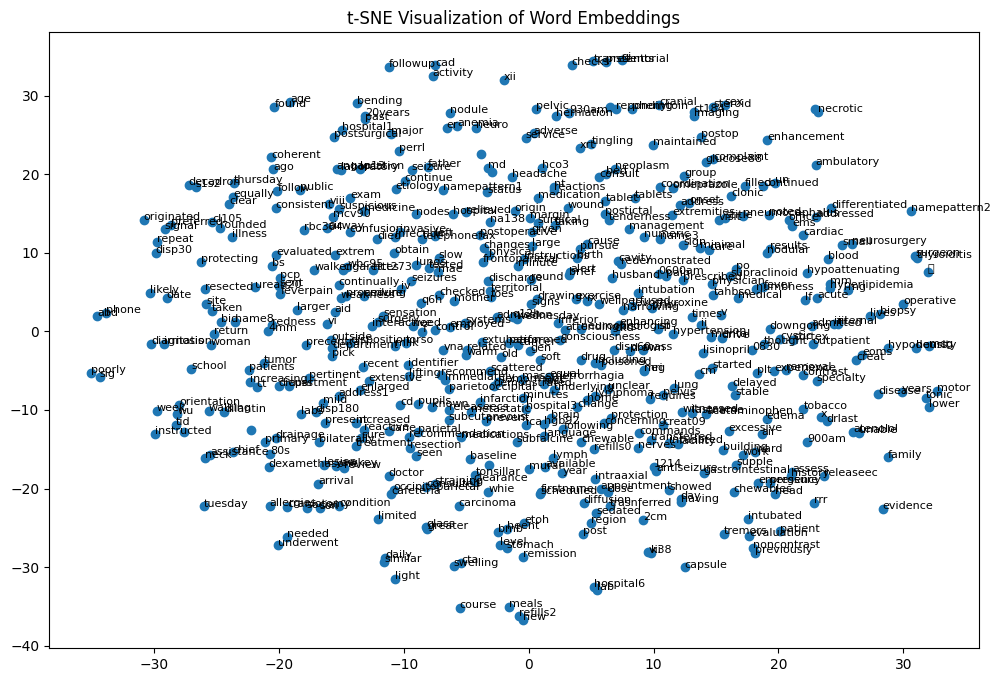

In [78]:
# create a t-SNE plot and visualize it

from sklearn.manifold import TSNE
import numpy as np

# Assuming model_nlpc is your trained Word2Vec model
# Get the word vectors
word_vectors = model_nlpc.wv

# Select a subset of words (optional, for better visualization)
vocab = list(word_vectors.key_to_index)[:500] # Example: first 500 words

# Extract vectors for the selected words
vectors = np.array([word_vectors[word] for word in vocab])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=15)  # Adjust perplexity if needed
tsne_results = tsne.fit_transform(vectors)

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])

# Add labels (optional, might be crowded for large vocabularies)
for i, word in enumerate(vocab):
    plt.annotate(word, xy=(tsne_results[i, 0], tsne_results[i, 1]), size=8)

plt.title('t-SNE Visualization of Word Embeddings')
plt.show()


In [79]:
# generate random sample of words from our model's vocab

import random

# Assuming model_nlpc is your trained Word2Vec model
# Get the vocabulary
vocab = list(model_nlpc.wv.key_to_index)

# Generate a random sample of words
sample_size = 50  # Adjust the sample size as needed
random_words = random.sample(vocab, sample_size)

random_words


['held',
 'head',
 'mcv90',
 'redemonstrated',
 'wand',
 'acute',
 'x',
 'extremities',
 'addressed',
 'noncontrast',
 'cortex',
 'greater',
 'bed',
 'service',
 'subcutaneous',
 'physician',
 'ambulatory',
 'viii',
 'facility',
 'etiology',
 'nodule',
 'years',
 '            ',
 'origin',
 'commands',
 'releaseec',
 'cancer',
 'frontoparietal',
 'ckd',
 'characteristics',
 'taking',
 '4mm',
 'atenolol',
 'hours',
 'laboratory',
 'rounded',
 'airway',
 'lungs',
 'straining',
 'mg',
 'reactions',
 'herniation',
 'downgoing',
 'subfalcine',
 'new',
 'mcg',
 'phenytoin',
 'checked',
 'posterior',
 'related']

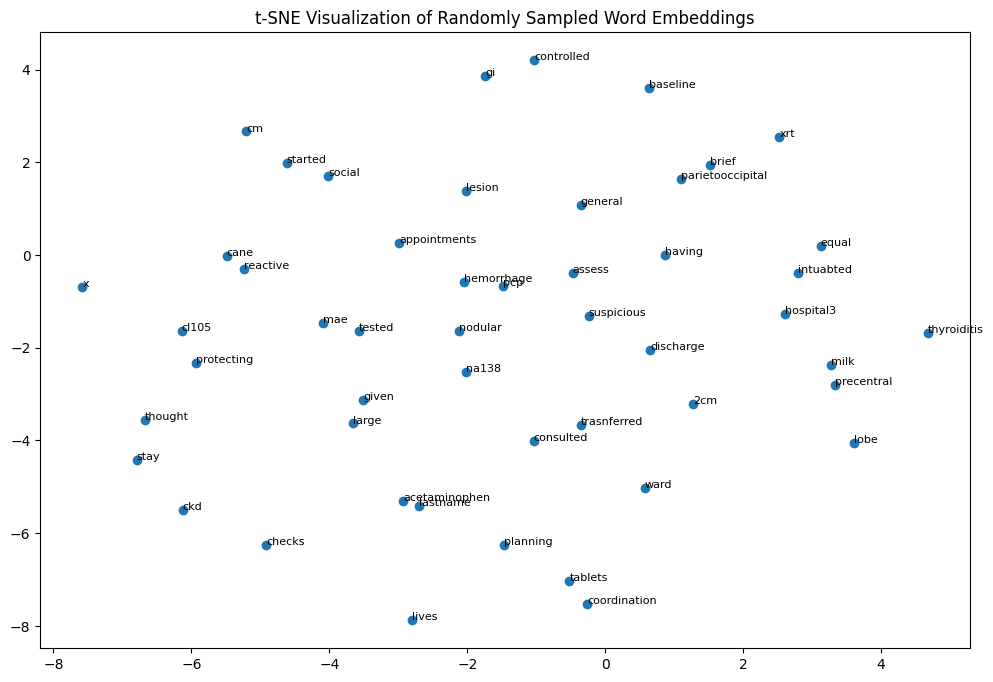

In [80]:
# Take a random sample of 50 words from our model’s vocabulary
# and plot the results in t-SNE graphs

import matplotlib.pyplot as plt
import numpy as np

# Get the vocabulary
vocab = list(model_nlpc.wv.key_to_index)

# Generate a random sample of words
sample_size = 50  # Adjust the sample size as needed
random_words = random.sample(vocab, sample_size)

# Extract vectors for the random sample
vectors = np.array([model_nlpc.wv[word] for word in random_words])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=15)
tsne_results = tsne.fit_transform(vectors)

# Visualize
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])

# Add labels
for i, word in enumerate(random_words):
    plt.annotate(word, xy=(tsne_results[i, 0], tsne_results[i, 1]), size=8)

plt.title('t-SNE Visualization of Randomly Sampled Word Embeddings')
plt.show()
